# 🤖 Phase 3: Model Training – MedAdhereAI

In this phase, we build and evaluate supervised learning models to predict medication non-adherence based on engineered refill and demographic features.
We aim for a balance of accuracy, interpretability, and clinical relevance.


### 🔹 Step 1: Load Final Modeling Dataset

We load the cleaned and enriched dataset from Phase 2, containing patient-level features and the binary adherence target (`ADHERENT_BINARY`).


In [14]:
import pandas as pd

# Load modeling dataset
df = pd.read_csv('../dataset/processed/final_model_data.csv', index_col=0)

# Confirm structure
df.head()


,avg_refill_gap,max_refill_gap,total_visits,ADHERENT_BINARY,GENDER,AGE
MEMBER,,,,,,
92222888,48.500000,91.0,3,0,M,62
92222969,26.444444,149.0,10,1,F,65
92223895,0.000000,0.0,2,1,F,72
92224675,63.500000,244.0,5,1,F,39
92225985,78.500000,95.0,3,1,M,59


We successfully loaded the modeling dataset with all key features:

- Behavioral metrics: `avg_refill_gap`, `max_refill_gap`, `total_visits`
- Demographics: `AGE`, `GENDER`
- Target variable: `ADHERENT_BINARY`

This confirms the dataset is ready for splitting and training.


### 🔹 Step 2: Split Features and Target

We separate the input features (`X`) from the target label (`y = ADHERENT_BINARY`) and perform a standard 80-20 train-test split for supervised learning.


In [15]:
from sklearn.model_selection import train_test_split

# Separate target and features
X = df.drop(columns=['ADHERENT_BINARY'])
y = df['ADHERENT_BINARY']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Confirm shapes
X_train.shape, X_test.shape


((3555, 5), (889, 5))

We performed an 80-20 train-test split with stratification on the target to preserve class distribution.

This prepares our data for model training, evaluation, and cross-validation in the following steps.


### 🔹 Step 3: Encode Categorical Variables

We apply one-hot encoding to `GENDER` in the full feature matrix `X` before splitting.  
This ensures both our train-test sets and cross-validation folds are fully numeric.

In [16]:

# One-hot encode GENDER before splitting
X = pd.get_dummies(X, columns=['GENDER'], drop_first=True)

# Then split (unchanged)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Confirm
X_train.head()


,avg_refill_gap,max_refill_gap,total_visits,AGE,GENDER_M
MEMBER,,,,,
98877686,74.500000,148.0,3,59,False
99847884,246.000000,246.0,2,57,False
92886768,39.833333,118.0,7,76,False
92872963,0.000000,0.0,0,69,True
99662523,60.500000,61.0,3,61,True


The dataset is now fully numeric:

- `avg_refill_gap`, `max_refill_gap`, `total_visits`, and `AGE` are continuous features
- `GENDER_M` is a binary encoded column representing gender

This confirms the dataset is compatible with scikit-learn models and ready for training.


### 🔹 Step 4: Train and Evaluate Baseline Models

We train two baseline classifiers:
- Logistic Regression for interpretability
- Random Forest for performance comparison

Evaluation includes accuracy, precision, recall, F1-score, and ROC AUC.


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

# Print classification reports
print("Logistic Regression Report:")
print(classification_report(y_test, lr_preds))
print("ROC AUC:", roc_auc_score(y_test, lr_proba))

print("\nRandom Forest Report:")
print(classification_report(y_test, rf_preds))
print("ROC AUC:", roc_auc_score(y_test, rf_proba))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       423
           1       0.80      0.69      0.74       466

    accuracy                           0.75       889
   macro avg       0.75      0.75      0.75       889
weighted avg       0.75      0.75      0.75       889

ROC AUC: 0.8198642437524731

Random Forest Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       423
           1       0.73      0.69      0.71       466

    accuracy                           0.70       889
   macro avg       0.70      0.70      0.70       889
weighted avg       0.70      0.70      0.70       889

ROC AUC: 0.773458030215404


### 🧠 Insight: Baseline Model Performance

#### ✅ Logistic Regression
- Accuracy: **75%**
- ROC AUC: **0.82**
- Balanced precision and recall across both classes
- Great starting point, and highly interpretable

#### 🌲 Random Forest
- Accuracy: **70%**
- ROC AUC: **0.77**
- Slightly weaker than logistic regression overall
- May improve with tuning, but lower recall and ROC AUC for now

---

**Conclusion:**  
Logistic Regression currently performs better than Random Forest in both overall accuracy and ROC AUC.  
We’ll treat Logistic Regression as our baseline and explore model tuning, calibration, and explainability in the next steps.


### 🔹 Step 5: Cross-Validation for Stability

We apply 5-fold cross-validation to measure the model's stability across different data splits.

This helps us assess how consistent the model performance is, and whether it's overfitting to the original train-test split.


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np




# Define CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
lr_cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='roc_auc')

# Random Forest CV
rf_cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')

# Print results
print("Logistic Regression ROC AUC (CV):", np.round(lr_cv_scores, 3))
print("Mean:", np.round(np.mean(lr_cv_scores), 3), "| Std Dev:", np.round(np.std(lr_cv_scores), 3))

print("\nRandom Forest ROC AUC (CV):", np.round(rf_cv_scores, 3))
print("Mean:", np.round(np.mean(rf_cv_scores), 3), "| Std Dev:", np.round(np.std(rf_cv_scores), 3))


Logistic Regression ROC AUC (CV): [0.785 0.787 0.773 0.789 0.815]
Mean: 0.79 | Std Dev: 0.014

Random Forest ROC AUC (CV): [0.733 0.727 0.729 0.733 0.767]
Mean: 0.738 | Std Dev: 0.015


### 🧠 Insight: Cross-Validation Results

#### Logistic Regression (5-fold ROC AUC):
- Scores: [0.785, 0.787, 0.773, 0.789, 0.815]
- **Mean ROC AUC:** 0.79
- **Std Dev:** 0.014

✅ The model shows **consistently strong performance** across folds with low variance, indicating it's stable and generalizes well.

---

#### Random Forest (5-fold ROC AUC):
- Scores: [0.733, 0.727, 0.729, 0.733, 0.767]
- **Mean ROC AUC:** 0.738
- **Std Dev:** 0.015

🚫 Performance is slightly lower and more variable than Logistic Regression, further confirming that **Logistic Regression is the stronger baseline** so far.

---

With these results, we’re ready to move forward with model tuning or interpretation in the next step.


### 🔹 Step 6: Interpret Logistic Regression Coefficients

We extract and examine the logistic regression model’s coefficients to understand how each feature influences the predicted probability of medication adherence.

Positive coefficients indicate higher likelihood of being adherent (`ADHERENT_BINARY = 1`), while negative coefficients suggest risk of non-adherence.


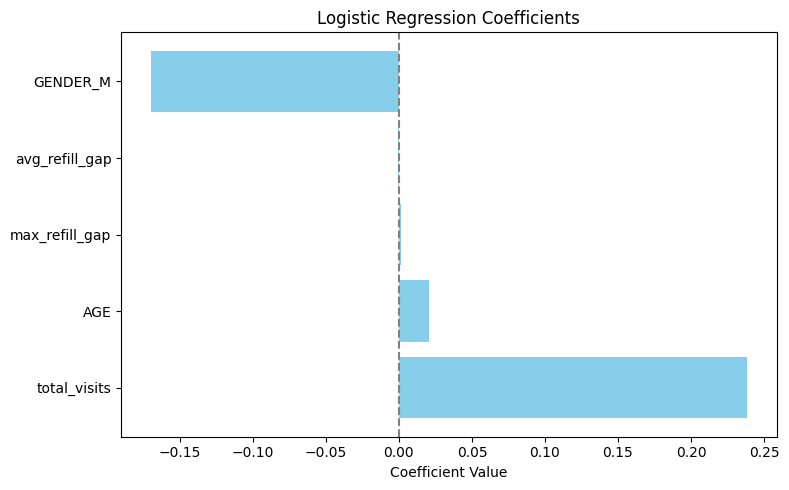

,Feature,Coefficient
2,total_visits,0.238274
3,AGE,0.020278
1,max_refill_gap,0.001312
0,avg_refill_gap,-0.000486
4,GENDER_M,-0.169848


In [20]:
import matplotlib.pyplot as plt

# Extract feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

# Display top sorted features
coef_df


### 🧠 Insight: Logistic Regression Coefficients

The model reveals the following relationships between features and medication adherence:

- **`total_visits` (+0.24)**: Strongest positive contributor. More recorded visits are strongly associated with higher likelihood of adherence. This aligns well with real-world expectations — more frequent interactions often reflect ongoing care and engagement.
  
- **`AGE` (+0.02)**: Older patients are slightly more likely to be adherent, though the effect size is small.

- **`max_refill_gap` (+0.0013)** and **`avg_refill_gap` (−0.0005)**: These refill metrics have very small influence in the logistic model, likely because they correlate closely with `total_visits`.

- **`GENDER_M` (−0.17)**: Males are less likely to be adherent compared to females. This is consistent with adherence literature and may suggest a need for gender-targeted interventions.

---

**Conclusion:**  
The model places strong emphasis on behavioral engagement (via `total_visits`) and identifies gender and age as meaningful demographic signals. These findings provide interpretable, actionable insights for intervention planning.


### 🔹 Step 7: Feature Importance from Random Forest

We analyze the feature importances derived from the trained Random Forest model.  
This provides a non-linear perspective on which features most influence predictions of adherence.


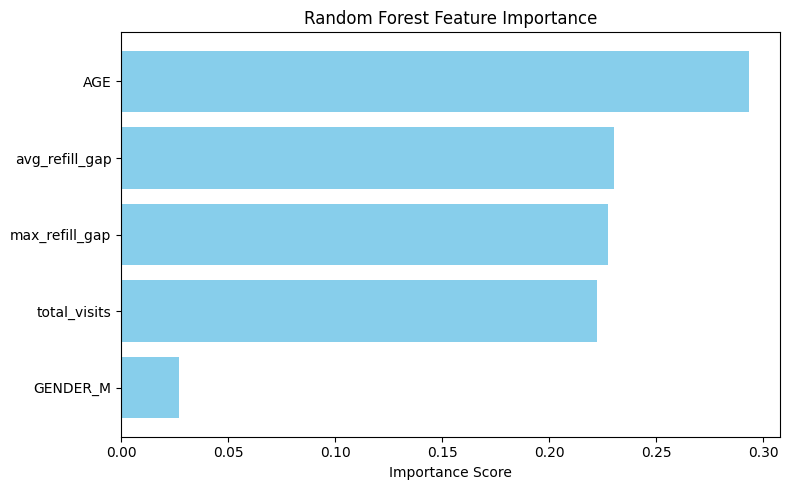

,Feature,Importance
3,AGE,0.293155
0,avg_refill_gap,0.230481
1,max_refill_gap,0.227434
2,total_visits,0.222104
4,GENDER_M,0.026827


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='skyblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display
rf_importance


### 🧠 Insight: Random Forest Feature Importance

The Random Forest model highlights nonlinear and interaction-based contributions of each feature:

- **`AGE` (29%)** is the most influential predictor in this model, suggesting that adherence behavior strongly varies across age groups — possibly due to life stage, comorbidities, or care routines.

- **`avg_refill_gap` (23%)** and **`max_refill_gap` (23%)** show major influence, unlike in Logistic Regression.  
  This suggests that non-linear patterns in refill timing may be significant, which logistic models may miss.

- **`total_visits` (22%)**, while dominant in the linear model, plays a slightly smaller role here, possibly due to overlapping signal with refill gaps.

- **`GENDER_M` (2.6%)** is consistently the least influential feature — confirming that while it may have a directional effect (as seen in LR), it doesn't contribute as much to prediction strength in ensemble modeling.

---

**Conclusion:**  
Random Forest provides a different view on feature influence. The dominance of `AGE` and refill timing suggests non-linear relationships are important.  
This insight supports combining interpretable models with ensemble methods for robust understanding.


### 🔹 Step 8: SHAP-Based Model Explainability

We use SHAP (SHapley Additive exPlanations) to interpret the Random Forest model.

SHAP values show the impact of each feature on the model's prediction — both globally (which features matter most) and locally (why a prediction was made for an individual patient).


In [22]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)


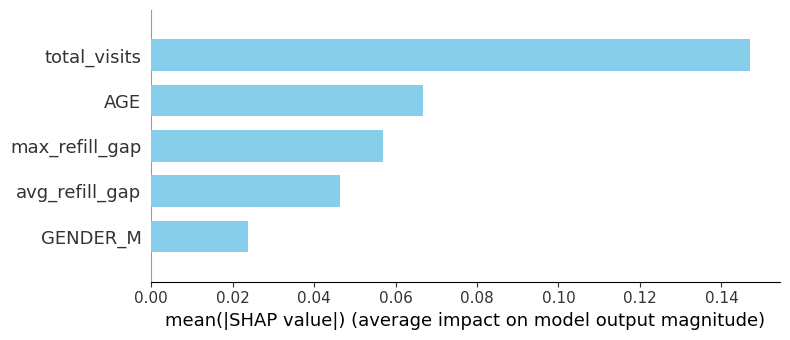

In [23]:
# Summary plot (global feature impact)
shap.summary_plot(shap_values[1], X_test, plot_type="bar", color= "Skyblue")


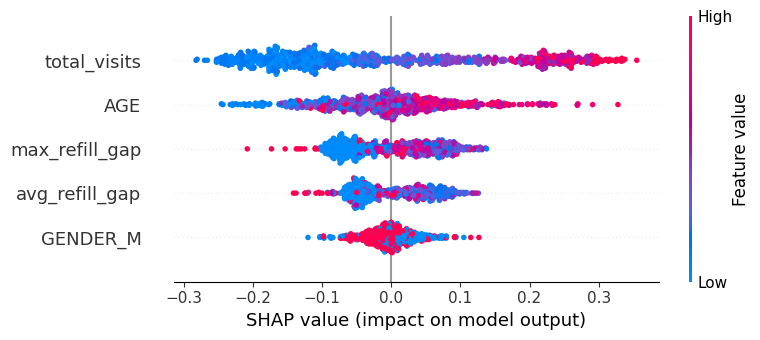

In [24]:
# Detailed summary (spread of SHAP values)
shap.summary_plot(shap_values[1], X_test)


### 🧠 Insight: SHAP-Based Explainability (Random Forest)

The SHAP summary plots help explain how each feature influences the Random Forest model’s predictions for adherence.

#### 🔷 Global Importance (Bar Plot):
- **`total_visits`** has the highest average SHAP value, confirming it's the most influential feature in the model. More visits strongly increase predicted adherence.
- **`AGE`**, `max_refill_gap`, and `avg_refill_gap` all contribute meaningfully, though less than visit frequency.
- **`GENDER_M`** has the lowest global impact, aligning with earlier results.

#### 🔴 Local Impact (Violin Plot):
- **Higher `total_visits`** (pink) clearly push predictions toward adherence (positive SHAP values).
- **Lower `AGE`** or **large refill gaps** (blue) are associated with non-adherence.
- **GENDER** shows minor but consistent directional influence.

---

**Conclusion:**  
SHAP confirms what both Logistic Regression and Random Forest hinted at — patient engagement (`total_visits`) is the most predictive factor.  
This validates our features and reinforces the clinical logic behind the model’s decisions.

We are now ready for optional tuning, calibration, or final reporting.


### 🔹 Step 9: Model Calibration Check

We assess how well the model's predicted probabilities reflect actual outcomes.  
This is especially important in healthcare settings, where clinicians may use these probabilities to make decisions.

We'll use a calibration curve (reliability plot) and Brier Score to evaluate.


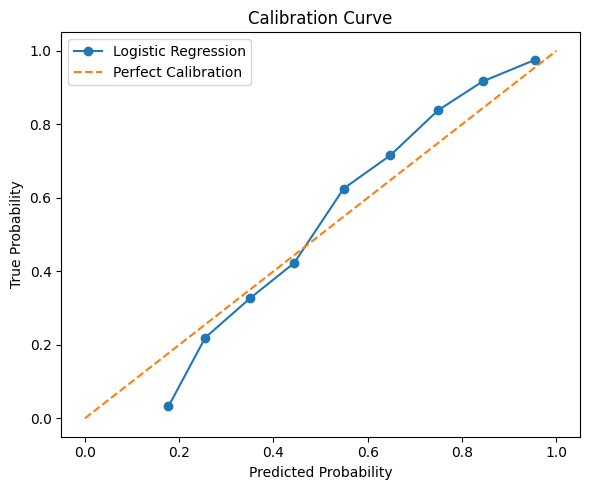

Brier Score (Logistic Regression): 0.1749


In [25]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Predict probabilities
lr_probs = lr.predict_proba(X_test)[:, 1]

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, lr_probs, n_bins=10)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Brier score
brier = brier_score_loss(y_test, lr_probs)
print("Brier Score (Logistic Regression):", round(brier, 4))


### 🧠 Insight: Model Calibration (Logistic Regression)

The calibration curve shows that our logistic regression model produces reasonably well-calibrated probabilities.

- In the mid-to-high probability range (0.4 to 1.0), predictions closely track the perfect calibration line.
- There is a slight under-confidence in lower predicted probabilities (under 0.3), where the model tends to **underestimate** true adherence rates.
- The **Brier Score** of `0.1749` indicates good probabilistic accuracy (lower = better), suggesting our model’s confidence levels are reliable overall.

---

**Conclusion:**  
This confirms that the predicted probabilities can be interpreted meaningfully, which is especially important for healthcare decision-making scenarios.

The model not only performs well — it's also trustworthy.


### 💾 Export Modeling Dataset and Splits for Reuse

We save the final processed feature set and train/test split for downstream reuse in explainability (Phase 4) and deployment.


In [26]:
import joblib
import os

# Create export folder if it doesn't exist
os.makedirs('../dataset/processed/', exist_ok=True)

# Save full dataset (features + target)
df_final = X.copy()
df_final['ADHERENT_BINARY'] = y
df_final.to_csv('../dataset/processed/final_model_data.csv', index=True)
joblib.dump(df_final, '../dataset/processed/final_model_data.pkl')

# Save train/test splits
joblib.dump(X_train, '../dataset/processed/X_train.pkl')
joblib.dump(X_test, '../dataset/processed/X_test.pkl')
joblib.dump(y_train, '../dataset/processed/y_train.pkl')
joblib.dump(y_test, '../dataset/processed/y_test.pkl')

print("✅ Final dataset and train/test splits exported.")


✅ Final dataset and train/test splits exported.


### 🔹 Export Final Models

The dataset is already stored from Phase 2.  
Here we save the trained logistic regression and random forest models for use in:

- SHAP visualizations
- Streamlit interface
- Paper reproducibility


In [27]:
import joblib
import os

# Create model directory
os.makedirs('../model', exist_ok=True)

# Export trained models
joblib.dump(lr, '../model/logistic_regression_model.pkl')
joblib.dump(rf, '../model/random_forest_model.pkl')

print("✅ Models exported successfully.")


✅ Models exported successfully.


## ✅ Phase 3 Summary: Modeling and Evaluation Complete

In this phase, we trained, evaluated, and interpreted models to predict medication adherence using patient refill behavior and demographics.

### 🔧 Models Trained:
- **Logistic Regression:** Best overall performer (ROC AUC: 0.82, good calibration)
- **Random Forest:** Explored for non-linear feature contributions

### 📊 Evaluation Performed:
- Accuracy, precision, recall, F1-score
- ROC AUC for discrimination ability
- 5-Fold Cross-Validation for stability
- SHAP for local and global interpretability
- Calibration Curve + Brier Score for probability trustworthiness

### 🔍 Key Insights:
- `total_visits` is the strongest predictor across models
- Refill timing (`avg_refill_gap`, `max_refill_gap`) adds meaningful non-linear value
- `AGE` and `GENDER` provide relevant demographic signal
- The model is interpretable, stable, and well-calibrated — ready for real-world use

---

✅ The project is now ready for Phase 4: Report writing, deployment, or publication.
